# Multi-Layer Perceptron

In [263]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torchvision.io import read_image
from torch import nn, optim
from matplotlib import cm
from matplotlib import style
%matplotlib widget
style.use('default')
#https://www.pluralsight.com/guides/building-your-first-pytorch-solution

## Data normalization

In [186]:
img_size = 224

#transform = transforms.Compose([transforms.ToTensor(),
#                                transforms.Resize((img_size, img_size)),
#                                transforms.Normalize((0.5,), (0.5,))])

#No normalization as document says.
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((img_size, img_size))])

In [187]:
#Code just to ease the load from local folder
import os
print(os.listdir("."))

from os import walk
for (dirpath, dirnames, filenames) in walk("."):
    print("Directory path: ", dirpath)
    print("Folder name: ", dirnames)
#     print("File name: ", filenames)

['dataset_train_test', 'dataset_train_test.zip', 'PAPILA_dataset.pdf', 'Readme.txt', 'Tests.docx', 'TP1 - Newton-Rhapson.ipynb', 'TP1 - Optimizacion de Funciones.ipynb', 'TP1 - Perceptron multi-capa.ipynb', 'TP_1_Optimizacion_Redes_Neuronales.lyx', 'TP_1_Optimizacion_Redes_Neuronales.lyx~', 'TP_1_Optimizacion_Redes_Neuronales.pdf']
Directory path:  .
Folder name:  ['dataset_train_test']
Directory path:  .\dataset_train_test
Folder name:  ['dataset_train_test']
Directory path:  .\dataset_train_test\dataset_train_test
Folder name:  ['test', 'train']
Directory path:  .\dataset_train_test\dataset_train_test\test
Folder name:  ['0', '1']
Directory path:  .\dataset_train_test\dataset_train_test\test\0
Folder name:  []
Directory path:  .\dataset_train_test\dataset_train_test\test\1
Folder name:  []
Directory path:  .\dataset_train_test\dataset_train_test\train
Folder name:  ['0', '1']
Directory path:  .\dataset_train_test\dataset_train_test\train\0
Folder name:  []
Directory path:  .\dataset_

## Loading data

torch.Size([32, 3, 224, 224])


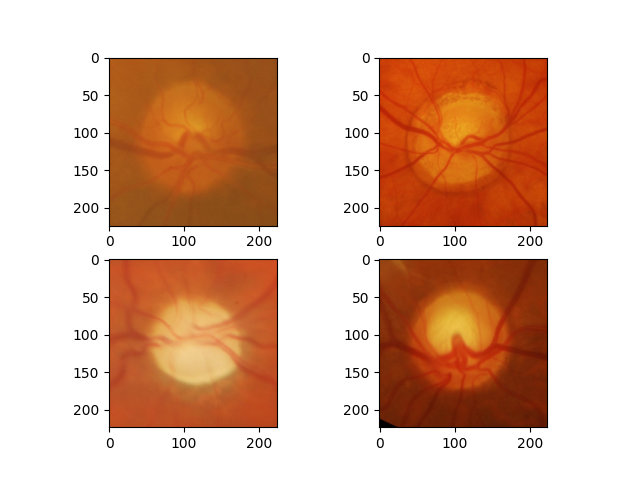

In [188]:
%matplotlib widget
#def load_test_train_data_MNIST():
#    trainset = datasets.MNIST(r'..\input\MNIST', download=True, train=True, transform=transform)
#    trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#    testset = datasets.MNIST(r'..\input\MNIST', download=True, train=False, transform=transform)
#    testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
#    return trainloader, testloader

from locale import normalize

from matplotlib.pyplot import imshow


def load_test_train_data_tp1():
    trainset = torchvision.datasets.ImageFolder(r'.\dataset_train_test\dataset_train_test\train',transform = transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

    testset = torchvision.datasets.ImageFolder(r'.\dataset_train_test\dataset_train_test\test',transform = transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, testloader

trainloader, testloader = load_test_train_data_tp1()
dataiter = iter(trainloader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.mT.shape)
#plt.imshow(images[0].T.numpy().squeeze(), cmap='gray_r');

fig, axs = plt.subplots(2,2)
axs[0,0].imshow(images[0].T.numpy().squeeze(), cmap='gray_r')
axs[0,1].imshow(images[1].T.numpy().squeeze(), cmap='gray_r')
axs[1,0].imshow(images[2].T.numpy().squeeze(), cmap='gray_r')
axs[1,1].imshow(images[3].T.numpy().squeeze(), cmap='gray_r')


#for i, img in enumerate(images):
#    plt.subplot(10,10,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    plt.imshow(img.T.numpy().squeeze(), cmap='gray_r')
    
#plt.show()


## Create Multi-layer perceptron network model

In [189]:
def create_MLP_model():
    # Model creation with neural net Sequential model
    model=nn.Sequential(nn.Linear(224*224*3,128), # 1 layer:- 784 input 128 o/p
                        #nn.Tanh(),
                        nn.ReLU(),          # Defining Regular linear unit as activation
                        #nn.Sigmoid(),
                        nn.Linear(128,64),  # 2 Layer:- 128 Input and 64 O/p
                        #nn.Tanh(),          # Defining Regular linear unit as activation
                        nn.Sigmoid(),
                        nn.ReLU(),
                        nn.Linear(64,2),   # 3 Layer:- 64 Input and 10 O/P as (0-9)
                        nn.LogSoftmax(dim=1) # Defining the log softmax to find the probablities for the last output unit
                      ) 
    return model


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on device: ", device)
mlp_model = create_MLP_model()

#moving models to device
mlp_model.to(device)
#create error criterion
criterion = nn.NLLLoss() 
print("MLP model")
print(mlp_model)


Running on device:  cuda
MLP model
Sequential(
  (0): Linear(in_features=150528, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Sigmoid()
  (4): ReLU()
  (5): Linear(in_features=64, out_features=2, bias=True)
  (6): LogSoftmax(dim=1)
)


## Train model

In [190]:
def train_model(model, criterion, epochs = 15, lr = 0.01):

    time0 = time()    
    running_loss_list= []
    epochs_list = []
    optimizer = optim.SGD(model.parameters(), lr= lr, momentum=0.9)
    for e in range(epochs):
        running_loss = 0
        
        #go for every batch
        for images, labels in trainloader:
            #move data to specific device
            images = images.to(device)
            labels = labels.to(device)
            # Flatenning MNIST images with size [64,784] (for MLP)
            
            images = images.view(images.shape[0], -1) 
            
            # defining gradient in each epoch as 0
            optimizer.zero_grad()            
            # modeling for each image batch
            output = model(images)

            # calculating the loss
            loss = criterion(output, labels)

            # This is where the model learns by backpropagating
            loss.backward()

            # And optimizes its weights here
            optimizer.step()

            # calculating the loss
            running_loss += loss.item()

        else:
            print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
    print("\nTraining Time (in minutes) =",(time()-time0)/60)
    return model

print("Training MLP model")
print("Device", next(mlp_model.parameters()).is_cuda)
mlp_model = train_model(mlp_model, criterion, epochs = 15, lr = 0.003)

Training MLP model
Device True
Epoch 0 - Training loss: 0.6715077124536037
Epoch 1 - Training loss: 0.6077899895608425
Epoch 2 - Training loss: 0.5316879376769066
Epoch 3 - Training loss: 0.4573585446923971
Epoch 4 - Training loss: 0.41798367258161306
Epoch 5 - Training loss: 0.3572083320468664
Epoch 6 - Training loss: 0.3426983915269375
Epoch 7 - Training loss: 0.33380916249006987
Epoch 8 - Training loss: 0.3309632632881403
Epoch 9 - Training loss: 0.2845221599563956
Epoch 10 - Training loss: 0.3990949224680662
Epoch 11 - Training loss: 0.2942474251613021
Epoch 12 - Training loss: 0.27581475116312504
Epoch 13 - Training loss: 0.3066742322407663
Epoch 14 - Training loss: 0.31422066083177924

Training Time (in minutes) = 0.591067636013031


## Test model

In [191]:
def test_model_mlp(testloader, model):
    correct_count, all_count = 0, 0
    for images,labels in testloader:
      #move data to specific device
      images = images.to(device)
      labels = labels.to(device)
      for i in range(len(labels)):
        img = images[i].view(1, 224*224*3)
        #evaluate model with no grad
        with torch.no_grad():
            logps = model(img)
        ps = torch.exp(logps)
        probab = list(ps.cpu().numpy()[0])
        #get predicted label
        pred_label = probab.index(max(probab))
        true_label = labels.cpu().numpy()[i]
        if(true_label == pred_label):
          correct_count += 1
        all_count += 1

    print("Number Of Images Tested =", all_count)
    print("Number Of Correct Tests =", correct_count)
    print("\nModel Accuracy =", (correct_count/all_count))



print("Testing MLP model")
test_model_mlp(testloader, mlp_model)

Testing MLP model
Number Of Images Tested = 210
Number Of Correct Tests = 160

Model Accuracy = 0.7619047619047619


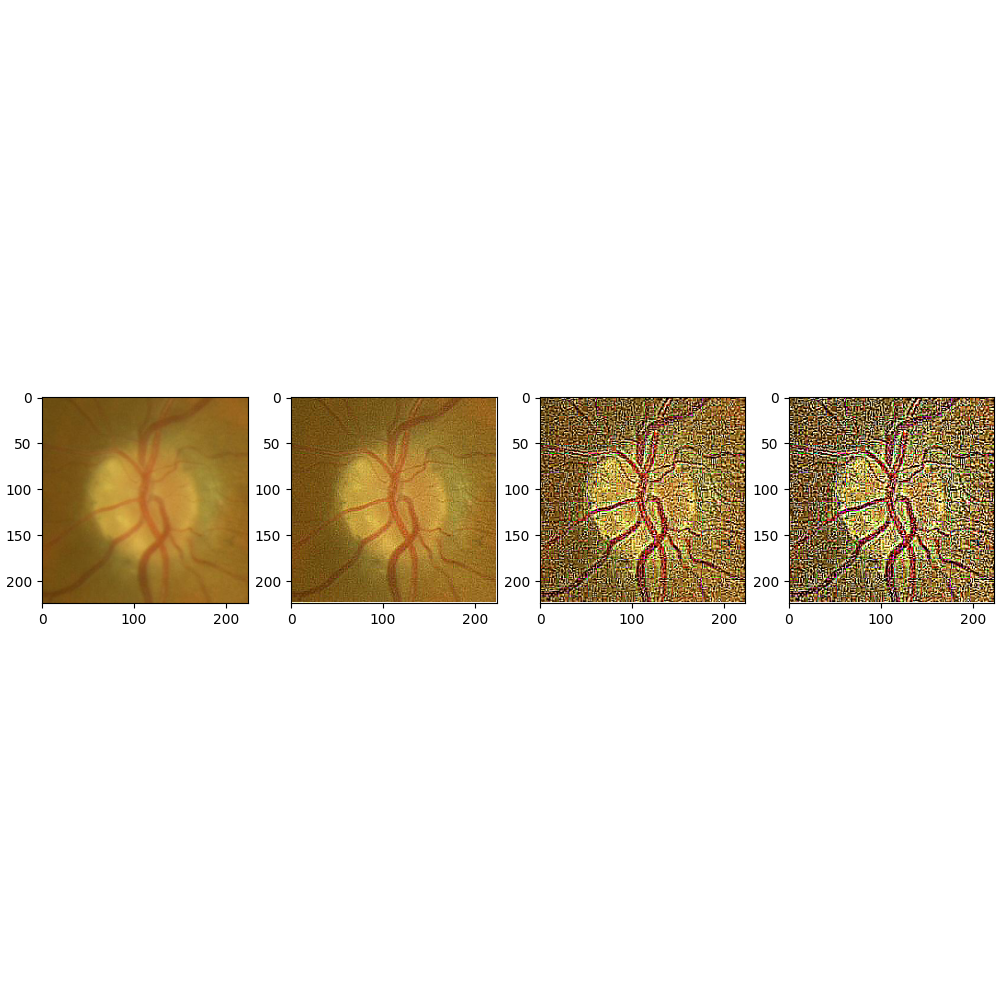

In [269]:
#Gaussian blur filter
def gaussian_blur():
    #Gaussian blur filter
    F = torch.tensor([[0.0625,0.125,0.0625],[0.125,0.25,0.125],[0.0625,0.125,0.0625]]).float()
    return F

### Convlution for unsharp masking
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

#Manual convlution method for 3 channel images.
def convolution(U,F):

    new_size = calculate_target_size(img_size=U.shape[1],kernel_size=U.shape[0])

    kernel=F

    kernel_shape = kernel.shape[0]

    conv_img = torch.zeros(3,new_size,new_size)
    
    for g in range(3):
        for i in range(new_size):
            for j in range(new_size):
                mat = U[g,i:i+kernel_shape,j:j+kernel_shape]
                conv_img[g, i, j] = torch.sum(torch.multiply(mat,kernel))

    #Add padding to the convuluted image so the size is the same for original and convoluted image.
    conv_img=torchvision.transforms.Pad(1)(conv_img)
    
    return conv_img

def unsharp_masking(U,amount):
    return U + (U-convolution(U,gaussian_blur())) * amount

U = read_image(r'.\dataset_train_test\dataset_train_test\train\0\Im106_ACRIMA.jpg') / 255
U=torchvision.transforms.Resize(224)(U)

def disp(x): return (x.clamp(0,1) * 255).byte().permute(1,2,0).cpu()

fig, (ax, bx, cx, dx) = plt.subplots(1,4, figsize=(10,10),label="Convolution test")
ax.imshow(disp(U))
bx.imshow(disp(unsharp_masking(U,10)))
cx.imshow(disp(unsharp_masking(U,100)))
dx.imshow(disp(unsharp_masking(U,150)))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
